This notebook was used to produce Table 3 and Figures 6, 10 of
>Anton Osokin, Anatole Chessel, Rafael E. Carazo Salas, Federico Vaggi<br>
GANs for Biological Image Synthesis<br>
In ICCV, 2017

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import torch

%matplotlib inline

In [2]:
file_template = 'reconstruction/{0}/reconstruction_data.pth'
file_template_sep = 'reconstruction-separable/{0}/reconstruction_data.pth'
model_folder_names = ['size-48-80_6class_gan-independent-sep-adam',
                      'size-48-80_6class_wgangp-independent-sep-adam',
                      'size-48-80_6class_gan-star-shaped-adam',
                      'size-48-80_6class_wgangp-star-shaped-adam']

model_legend_names = ['GAN-sep',
                      'WGAN-GP-sep',
                      'GAN-star',
                      'WGAN-GP-star']

class_names = ['Alp14', 'Arp3', 'Cki2', 'Mkh1', 'Sid2', 'Tea1']

In [3]:
def mad(arr):
    med = np.median(arr)
    return np.median(np.abs(arr - med))

def print_info(model, lls, dists):
    lls = np.array(lls)
    dists = np.array(dists)
    print('NLL={0:0.0f}\u00B1{1:0.0f}; L2={2:0.3f}\u00B1{3:0.3f} - {4}'.format(np.median(lls), mad(lls),
                                                                               np.median(dists), mad(dists),
                                                                               model))

def print_stats(file_template, model_folder_names, class_names, model_legend_names=None):
    if model_legend_names is None:
        model_legend_names = model_folder_names
    lls_all = {m: [] for m in model_folder_names}
    dists_all = {m: [] for m in model_folder_names}
    for cl in class_names:
        print('Class', cl)
        for i_model, model in enumerate(model_folder_names):
            data = torch.load(file_template.format(model))
            lls = data['lls_noise'][cl]
            dists = data['l2_dists'][cl]
            print_info(model_legend_names[i_model], lls, dists)
            lls_all[model] += lls
            dists_all[model] += dists

    print('6 classes')
    for i_model, model in enumerate(model_folder_names):
        print_info(model_legend_names[i_model], lls_all[model], dists_all[model])       
        
def do_scatter_plots(file_template, model_folder_names, class_names, model_legend_names=None,
                     nn_data=None, nll_mean=None, nll_std=None, save_prefix=None):
    if model_legend_names is None:
        model_legend_names = model_folder_names
    lls = []
    dists = []
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    for cl in class_names:
        fig = plt.figure(figsize=(3, 3))
        ax = fig.add_subplot(111)

        for i_model, model in enumerate(model_folder_names):
            data = torch.load(file_template.format(model))
            lls = data['lls_noise'][cl]
            dists = data['l2_dists'][cl]
            ax.scatter(dists, lls)

        ax.legend(model_legend_names)
        ax.set_xlabel(r'$L_2$-error')
        ax.set_ylabel(r'NLL')
        # ax.set_title(cl)

        if nn_data is not None:
            ax.plot([nn_data[cl][0], nn_data[cl][0]], [0, 500], "-", color='gray', zorder=-100)
            # ax.plot([nn_data[cl][0] + nn_data[cl][1] * 3, nn_data[cl][0] + nn_data[cl][1] * 3], [0, 500], "--", color='gray')
            # ax.plot([nn_data[cl][0] - nn_data[cl][1] * 3, nn_data[cl][0] - nn_data[cl][1] * 3], [0, 500], "--", color='gray')
        if nll_mean is not None:
            ax.plot([0, 1], [nll_mean, nll_mean], "-", color='gray', zorder=-100)
            if nll_std is not None:
                ax.plot([0, 1], [nll_mean + 3 * nll_std, nll_mean + 3 * nll_std], "--", color='gray', zorder=-100)
                ax.plot([0, 1], [nll_mean - 3 * nll_std, nll_mean - 3 * nll_std], "--", color='gray', zorder=-100)
                
        ax.axis((0.02, 0.14, 100, 400))
        if save_prefix is not None:
            fig.savefig(save_prefix + '_' + cl + '.pdf', bbox_inches='tight')
        plt.show()
        

In [4]:
# get the nearest neighbor distances
data = torch.load(file_template.format(model_folder_names[1]))

def print_nn_info(dists):
    dists = np.array(dists)
    dists_median = np.median(np.array(dists))
    dists_mad = mad(np.array(dists))
    print('L2={0:0.3f}\u00B1{1:0.3f}'.format(dists_median, dists_mad))
    return dists_median, dists_mad

def print_nn_dists(data, class_names):
    nn_data = {}
    dists_all = []
    for cl in class_names:
        print('Class', cl, end=': ')
        dists = data['nn_dists'][cl]
        dists_median, dists_mad = print_nn_info(dists)
        dists_all += dists
        nn_data[cl] = (dists_median, dists_mad)

    print('6 classes')
    dists_median, dists_mad = print_nn_info(dists_all)
    nn_data['all'] = (dists_median, dists_mad)
    return nn_data
    
nn_data = print_nn_dists(data, class_names)

Class Alp14: L2=0.081±0.007
Class Arp3: L2=0.084±0.008
Class Cki2: L2=0.081±0.011
Class Mkh1: L2=0.078±0.011
Class Sid2: L2=0.076±0.010
Class Tea1: L2=0.075±0.009
6 classes
L2=0.079±0.009


Mean: 142; std: 7


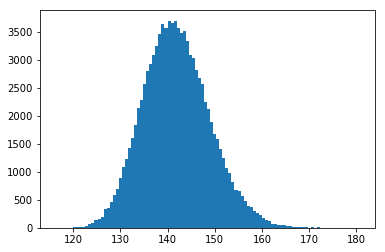

In [5]:
# compute the mean and std of distance to the origin of the Gaussian samples
np.random.seed(42)
noise_dim = 100
mvn = multivariate_normal(np.zeros(noise_dim), np.identity(noise_dim))
points = mvn.rvs(size=100000)
nlls = -mvn.logpdf(points)
nll_mean, nll_std = np.mean(nlls), np.std(nlls)
plt.hist(nlls, bins=100)
print('Mean: {0:0.0f}; std: {1:0.0f}'.format(nll_mean, nll_std))

In [6]:
print_stats(file_template, model_folder_names, class_names, model_legend_names=model_legend_names)

Class Alp14
NLL=186±20; L2=0.052±0.006 - GAN-sep
NLL=154±8; L2=0.043±0.005 - WGAN-GP-sep
NLL=158±11; L2=0.058±0.006 - GAN-star
NLL=155±9; L2=0.040±0.005 - WGAN-GP-star
Class Arp3
NLL=151±12; L2=0.062±0.006 - GAN-sep
NLL=155±8; L2=0.047±0.005 - WGAN-GP-sep
NLL=139±9; L2=0.060±0.006 - GAN-star
NLL=151±7; L2=0.045±0.006 - WGAN-GP-star
Class Cki2
NLL=183±24; L2=0.051±0.008 - GAN-sep
NLL=151±10; L2=0.041±0.006 - WGAN-GP-sep
NLL=144±10; L2=0.060±0.008 - GAN-star
NLL=157±11; L2=0.039±0.005 - WGAN-GP-star
Class Mkh1
NLL=164±14; L2=0.051±0.007 - GAN-sep
NLL=149±7; L2=0.040±0.005 - WGAN-GP-sep
NLL=116±3; L2=0.079±0.007 - GAN-star
NLL=147±7; L2=0.040±0.006 - WGAN-GP-star
Class Sid2
NLL=166±13; L2=0.049±0.006 - GAN-sep
NLL=145±6; L2=0.042±0.005 - WGAN-GP-sep
NLL=136±5; L2=0.058±0.007 - GAN-star
NLL=147±7; L2=0.040±0.005 - WGAN-GP-star
Class Tea1
NLL=153±11; L2=0.051±0.006 - GAN-sep
NLL=144±6; L2=0.043±0.005 - WGAN-GP-sep
NLL=140±9; L2=0.058±0.007 - GAN-star
NLL=146±7; L2=0.041±0.005 - WGAN-GP-star

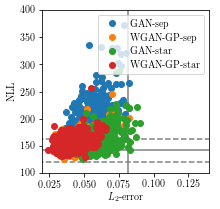

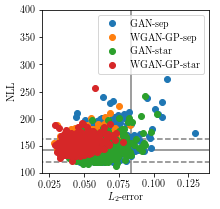

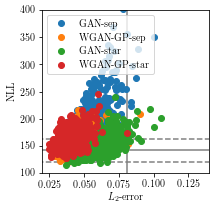

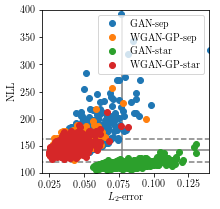

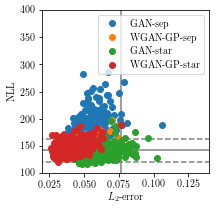

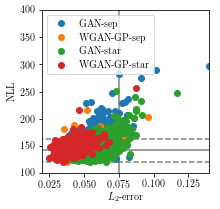

In [7]:
do_scatter_plots(file_template, model_folder_names, class_names, model_legend_names,
                 nn_data, nll_mean, nll_std, save_prefix='reconstruction-regular')

In [8]:
print_stats(file_template_sep, model_folder_names, class_names, model_legend_names=model_legend_names)

Class Alp14
NLL=151±10; L2=0.068±0.007 - GAN-sep
NLL=144±7; L2=0.065±0.007 - WGAN-GP-sep
NLL=143±8; L2=0.069±0.007 - GAN-star
NLL=141±6; L2=0.062±0.006 - WGAN-GP-star
Class Arp3
NLL=167±14; L2=0.076±0.008 - GAN-sep
NLL=144±6; L2=0.068±0.006 - WGAN-GP-sep
NLL=141±7; L2=0.071±0.007 - GAN-star
NLL=141±5; L2=0.066±0.006 - WGAN-GP-star
Class Cki2
NLL=155±11; L2=0.070±0.010 - GAN-sep
NLL=143±6; L2=0.067±0.009 - WGAN-GP-sep
NLL=142±7; L2=0.074±0.010 - GAN-star
NLL=140±5; L2=0.065±0.010 - WGAN-GP-star
Class Mkh1
NLL=158±12; L2=0.073±0.016 - GAN-sep
NLL=146±6; L2=0.057±0.011 - WGAN-GP-sep
NLL=141±7; L2=0.122±0.010 - GAN-star
NLL=398±92; L2=0.041±0.006 - WGAN-GP-star
Class Sid2
NLL=162±15; L2=0.065±0.012 - GAN-sep
NLL=142±5; L2=0.055±0.008 - WGAN-GP-sep
NLL=141±6; L2=0.073±0.008 - GAN-star
NLL=142±5; L2=0.053±0.008 - WGAN-GP-star
Class Tea1
NLL=154±11; L2=0.059±0.008 - GAN-sep
NLL=141±5; L2=0.053±0.007 - WGAN-GP-sep
NLL=142±6; L2=0.066±0.007 - GAN-star
NLL=141±5; L2=0.054±0.007 - WGAN-GP-star
6 

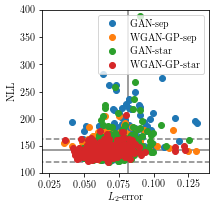

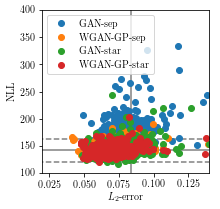

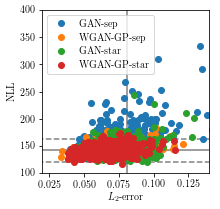

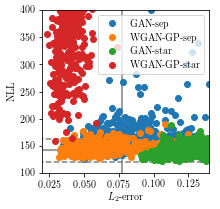

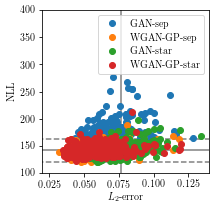

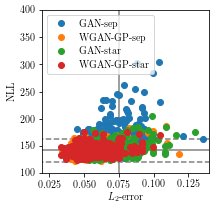

In [9]:
do_scatter_plots(file_template_sep, model_folder_names, class_names, model_legend_names,
                 nn_data, nll_mean, nll_std, save_prefix='reconstruction-separable')